# Mu-Star Analysis Plot

This notebooks has the plot presented on the mu-star telecon on Mar 22.

### Packages

In [6]:
import sys
sys.path.append("/home/s1/jesteves/git/ccopa/python")
from main import copacabana
from make_input_files.make_input_datasets import *

In [7]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

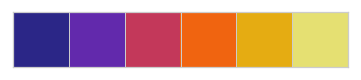

In [8]:
import seaborn as sns; sns.set(color_codes=True)
sns.set_style("whitegrid")
sns.palplot(sns.color_palette("CMRmap"))

In [9]:
colorGradient = sns.color_palette("CMRmap")[:5]

In [10]:
from astropy.table import Table, vstack, join
from astropy.io.fits import getdata

### Loading Datasets

In [11]:
run_rhod  = ['emu-r200-z3','g001-r200','g003-r200','g005-r200']
pz_label  = ['emuBPZ'   ,'gauss001'   ,'gauss003'   ,'gauss005'     ]
z_window  = [0.03, 0.01, 0.03, 0.05]

# run_rhod  = [runs.format('rhod') for runs in run_root]
# run_r200  = [runs.format('r200') for runs in run_root]

In [13]:
cfg = '../config_files/config_buzzard_v2.yaml'
copa = copacabana(cfg)

def read_file(run_name,old=False):
    if old: run_name += '_old'
    cat   = copa.load_copa_out('cluster',run=run_name)
    return cat

def match_cats(cat1,cat2):
    cat2 = join(cat2,cat1['CID','M200_true','R200_true'],keys='CID')
    return cat1, cat2

def header(name):
    print('\n'+name)

master file: 
 /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/output/tiles/buzzard_v2.0.0_copa_golden_00001.hdf5
/data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/output/tiles/buzzard_v2.0.0_copa_golden_00002.hdf5
/data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/output/tiles/buzzard_v2.0.0_copa_golden_00003.hdf5
/data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/output/tiles/buzzard_v2.0.0_copa_golden_00004.hdf5
/data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/output/tiles/buzzard_v2.0.0_copa_golden_00005.hdf5
/data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/output/tiles/buzzard_v2.0.0_copa_golden_00006.hdf5
/data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/output/tiles/buzzard_v2.0.0_copa_golden_00007.hdf5
/data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/output/tiles/buzzard_v2.0.0_copa_golden_00008.hdf5
/data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/output/tiles/buzzard_v2.0.0_copa_golden_00009.hdf5
/data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/output/tiles/buzzard_v2.0.0_copa_gol

In [14]:
data_rhod,data_rhod_old = [],[]
for run, label in zip(run_rhod,pz_label):
    header('Loading: '+run)
    cat1 = read_file(run)
    
    #cat2 = read_file(run, old=True)
    #cat1,cat2 = match_cats(cat1,cat2)
    
    if 'MU_TRUE' not in cat1.colnames:
        print('mu-star missing in copa')
    
    #if 'MU_TRUE' not in cat2.colnames:
    #    print('mu-star missing in old')
    
    data_rhod.append(cat1)
    #data_rhod_old.append(cat2)


Loading: emu-r200-z3

Loading: g001-r200

Loading: g003-r200

Loading: g005-r200


In [15]:
ylabel    = r'$\left( \mu_{\star}/\mu_{\star}^{True} \right)$'

In [16]:
## colors
blue = '#2E86C1'
gray = '#A6ACAF'
red = '#A93226'

In [120]:
def remove_outliers(x,n=1.5):
    q25,q75 = np.nanpercentile(x,[25,75])
    iqr     = q75-q25
    lo, up  = q25-n*iqr, q75+n*iqr
    mask    = (x<up)&(x>lo)
    return mask

def get_scatter(x,xt):
    residual     = x/xt
    log_residual = np.log10(residual)
    
    check    = np.logical_not(np.isnan(log_residual) | np.isinf(log_residual))
    mask     = remove_outliers(log_residual,n=1.5)&(check)
    
    bias            = 10**np.nanmean(log_residual[mask])
    log_scatter     = np.nanstd(log_residual[mask])
    scatter         = 10**(log_scatter)-1
    
    out_fraction    = 1-1.*np.count_nonzero(mask)/len(x)
    out = {'residual':residual,'log_residual':log_residual,'bias': bias, 
           'scatter':scatter, 'log_scatter':log_scatter, 'outlier_fraction': out_fraction,'mask':mask}
    return out

def plot_scatter_distribution(ngals,ngalst,label="data",xmin=0.25,xmax=2.25,logx=False):
    w = np.where(ngalst>1)[0]
    res  = get_scatter(ngals[w],ngalst[w])
    print(r'mean: %.3f'%(res['bias']))
    print(r'rms : %.3f'%(res['scatter']))
    print(r'out. frac. : %.3f'%(res['outlier_fraction']))
    
    if logx:
        xbins    = np.linspace(np.log10(xmin),np.log10(xmax),30)
        residual = res['log_residual']
        xm       = np.log10(res['bias'])
        xlo,xup  = xm-2*res['log_scatter'],xm+2*res['log_scatter']
        
    else:
        xbins = np.linspace(xmin,xmax,30)
        residual = res['residual']
        xm       = res['bias']
        xlo,xup  = 10**(np.log10(xm)-2*res['log_scatter']),10**(np.log10(xm)+2*res['log_scatter'])
    print(xbins)
    check     = np.logical_not(np.isnan(residual))&np.logical_not(np.isinf(residual))
    _ = plt.hist(residual[check],bins=xbins,label='out. perc = %.2f %%'%(100*res['outlier_fraction']))
    _ = plt.hist(residual[res['mask']],bins=xbins,label=r'precision = %.2f %%'%(100*res['scatter']))
    plt.axvline(xm,color='k',ls='--')
    plt.axvline(xlo,color='r',ls='--')
    plt.axvline(xup,color='r',ls='--')
    plt.title(label)
    # plt.yscale('log')
    plt.xlabel('ratio')
    plt.legend()

/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.


mean: 0.955
rms : 0.507
out. frac. : 0.041
[-1.         -0.94906478 -0.89812957 -0.84719435 -0.79625914 -0.74532392
 -0.69438871 -0.64345349 -0.59251827 -0.54158306 -0.49064784 -0.43971263
 -0.38877741 -0.3378422  -0.28690698 -0.23597176 -0.18503655 -0.13410133
 -0.08316612 -0.0322309   0.01870431  0.06963953  0.12057474  0.17150996
  0.22244518  0.27338039  0.32431561  0.37525082  0.42618604  0.47712125]


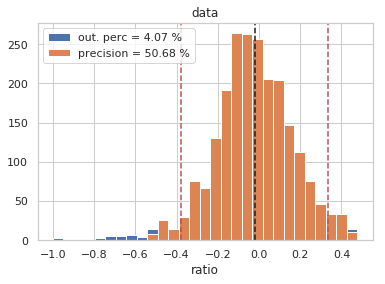

In [122]:
plot_scatter_distribution(data_rhod[1]['Ngals'],data_rhod[0]['Ngals_true'],xmin=1e-1,xmax=3.,logx=True)

### Checking Plots

#### Plot 1: $R_{200}$ vs $R_{200,true}$

Check if the R200 is the True one

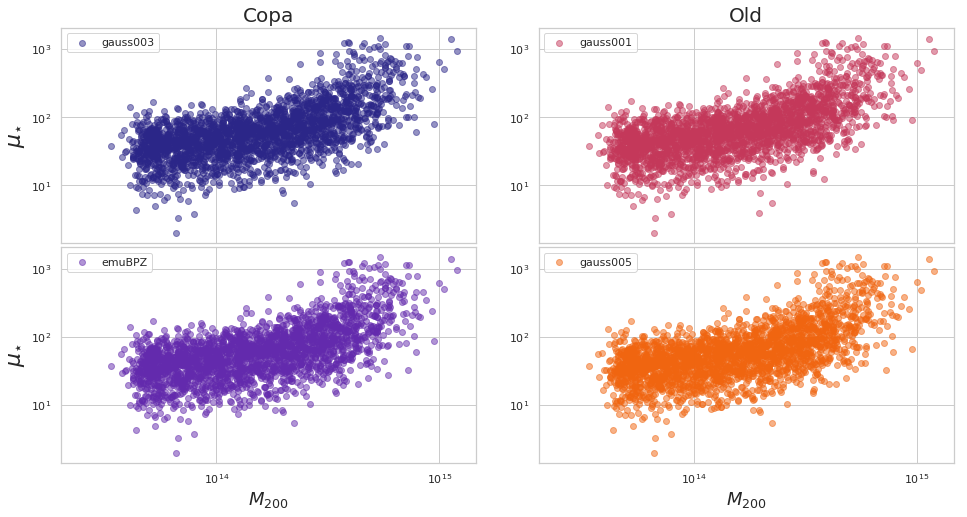

In [88]:
xlabel=r'$M_{200}$'
ylabel=r'$\mu_{\star}$'
fig, ax = plt.subplots(2, 2, sharey='col',sharex='all', figsize=(16,8))
fig.subplots_adjust(hspace=0.02,wspace=0.15)

ax = ax.flatten(order='F')

datas = data_rhod

i=0
for d,color in zip(datas, colorGradient):
    ax[i].scatter(d['M200_true'],d['MU_TRUE'],label=pz_label[i],color=color,alpha=0.5)
    ax[i].legend(loc=0)
    i+=1
ax[0].set_title('Copa',fontsize=20)
ax[2].set_title('Old',fontsize=20)
ax[0].set_ylabel(ylabel,fontsize=22)
ax[1].set_ylabel(ylabel,fontsize=22)
ax[1].set_xlabel(xlabel,fontsize=18)
ax[3].set_xlabel(xlabel,fontsize=18)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[2].set_yscale('log')

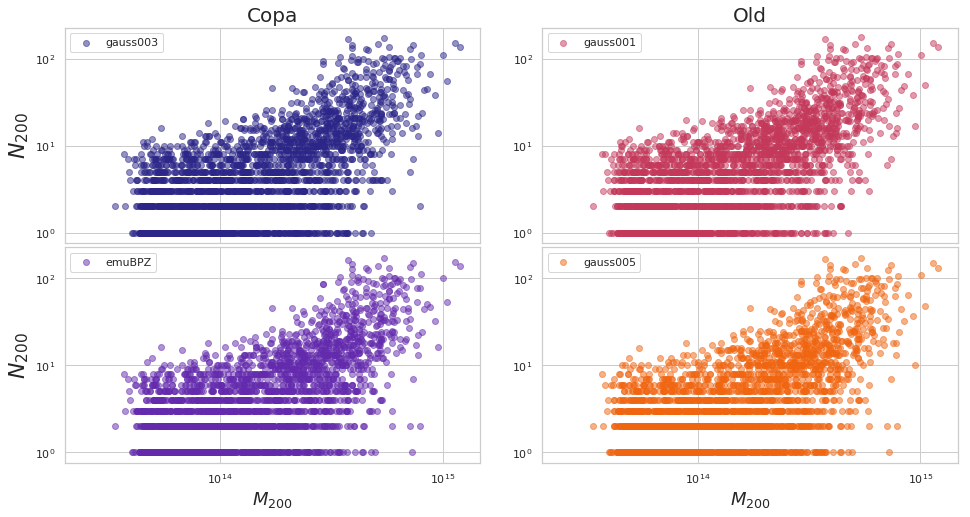

In [90]:
xlabel=r'$M_{200}$'
ylabel=r'$N_{200}$'
fig, ax = plt.subplots(2, 2, sharey='col',sharex='all', figsize=(16,8))
fig.subplots_adjust(hspace=0.02,wspace=0.15)

ax = ax.flatten(order='F')

datas = data_rhod

i=0
for d,color in zip(datas, colorGradient):
    ax[i].scatter(d['M200_true'],d['Ngals_true'],label=pz_label[i],color=color,alpha=0.5)
    ax[i].legend(loc=0)
    i+=1
ax[0].set_title('Copa',fontsize=20)
ax[2].set_title('Old',fontsize=20)
ax[0].set_ylabel(ylabel,fontsize=22)
ax[1].set_ylabel(ylabel,fontsize=22)
ax[1].set_xlabel(xlabel,fontsize=18)
ax[3].set_xlabel(xlabel,fontsize=18)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[2].set_yscale('log')

In [89]:
sns.set_context("talk")

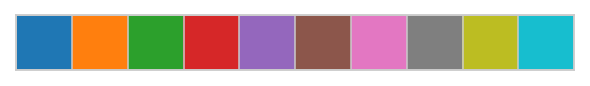

In [90]:
cgrad2= sns.color_palette("tab10")[:4]
sns.palplot(sns.color_palette("tab10"))

### Comparing

NameError: name 'data_r200' is not defined

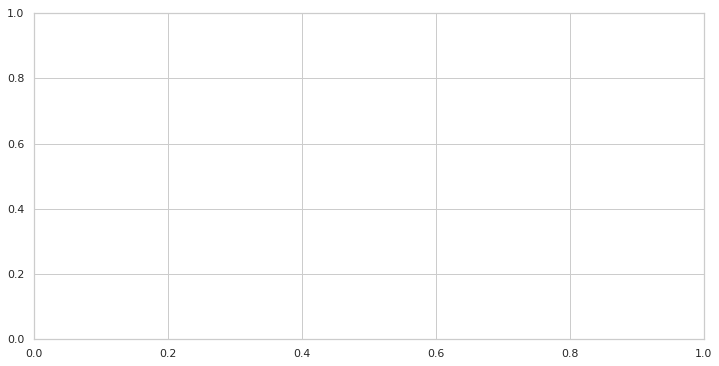

In [30]:
xlabel=r'redshift'
ylabel= r'$ \mu_{\star}^{copa}/\mu_{\star}^{old}$'

fig, ax = plt.subplots(1, 1, sharey='all', sharex='all', figsize=(12,6))
fig.subplots_adjust(hspace=0.02,wspace=0.05)

# ax    = ax.flatten(order='F')

i=0
for d1, d2, run, label, color in zip(data_r200,data_r200_old,run_rhod,pz_label,cgrad2):
    if i>1:
        plot_frac_error(i*0.001+d1['redshift'],d1['MU'],d2['MU'], d1['MU_ERR_JK'], d2['MU_ERR_JK'], ax=ax, co=color,label=label)
    #ax[i].legend()
    i+=1
ax.legend()
# ax.set_ylim(-0.2,3.8)
ax.set_ylabel(ylabel,fontsize=24)
ax.set_xlabel(xlabel,fontsize=18)
plt.suptitle(r'Comparasion with same aperture : $R_{200}$')
plt.savefig('graphs/comparasion_ratio_evolution_gauss_pz_w_r200_aperture.png')

NameError: name 'data_r200' is not defined

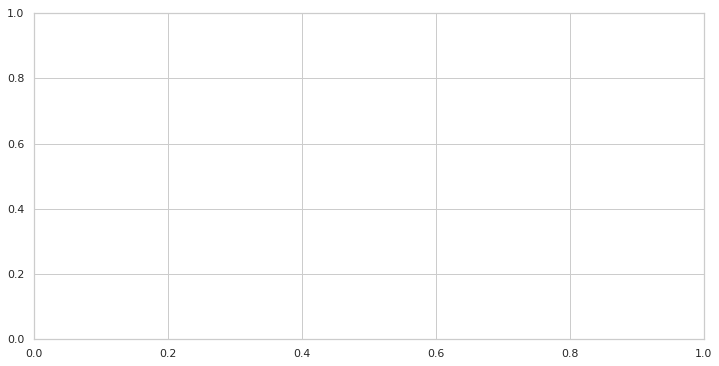

In [31]:
xlabel=r'redshift'
ylabel= r'$\mu_{\star}^{copa}/\mu_{\star}^{old}$'

fig, ax = plt.subplots(1, 1, sharey='all', sharex='all', figsize=(12,6))
fig.subplots_adjust(hspace=0.02,wspace=0.05)

# ax    = ax.flatten(order='F')
labels = ['BPZ       : CosmoDC2','emuBPZ: DES Y1',None,None]
i=0
for d1, d2, run, label, color in zip(data_r200,data_r200_old,run_rhod,labels,cgrad2):
    if i==1:
        plot_frac_error(i*0.01+d1['redshift'],d1['MU'],d2['MU'], d1['MU_ERR_JK'], d2['MU_ERR_JK'], ax=ax, co=color,label=label)
#         plot_frac_error(i*0.01+d1['redshift'],d1['Ngals'],d2['Ngals'], 0.*d1['MU_ERR_JK'], 0.*d2['MU_ERR_JK'], ax=ax, co=color,label=label)
    #ax[i].legend()
    i+=1
ax.legend()
# ax.set_ylim(-0.2,3.8)
ax.set_ylabel(ylabel,fontsize=24)
ax.set_xlabel(xlabel,fontsize=18)
plt.suptitle(r'Comparasion with same aperture : $R_{200}$')
plt.savefig('graphs/comparasion_ratio_evolution_bpz_pz_w_r200_aperture.png')

### Old Membership Results

Text(0.5,0.98,'Old Memb. : $R_{HOD}$ method')

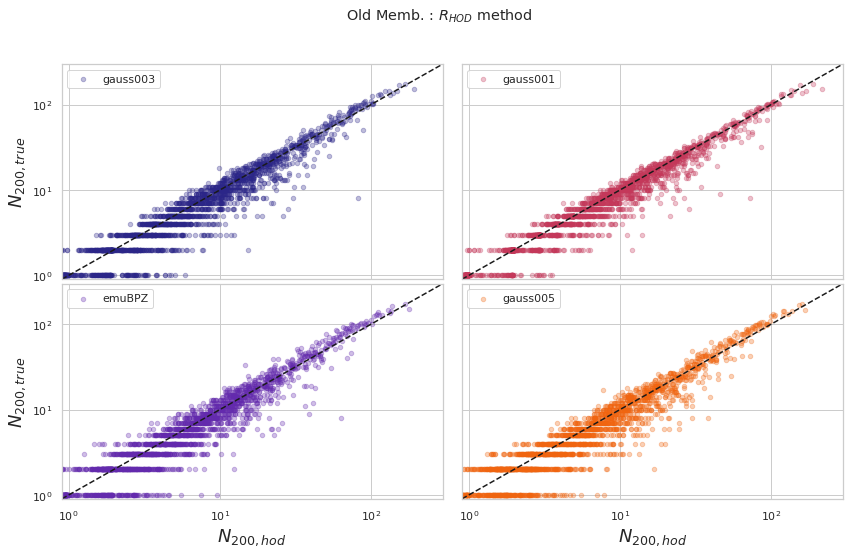

In [52]:
xlabel=r'$N_{200,hod}$'
ylabel=r'$N_{200,true}$'

fig, ax = plt.subplots(2, 2, sharey='all', sharex='all', figsize=(14,8))
fig.subplots_adjust(hspace=0.02,wspace=0.05)

ax = ax.flatten(order='F')

i=0
for d, run, label, color in zip(data_rhod,run_rhod,pz_label,colorGradient):
    ax[i].scatter(d['Ngals'],d['Ngals_true'],label=label,color=color,alpha=0.3,s=20)
    ax[i].plot([0.9,300],[0.9,300],'k--')
    ax[i].legend()
    i+=1

ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].set_ylim(0.9,300)
ax[0].set_xlim(0.9,300)
ax[0].set_ylabel(ylabel,fontsize=18)
ax[1].set_ylabel(ylabel,fontsize=18)
ax[1].set_xlabel(xlabel,fontsize=18)
ax[3].set_xlabel(xlabel,fontsize=18)
plt.suptitle(r'Old Memb. : $R_{HOD}$ method')

Text(0.5,0.98,'Old Memb. : $R_{HOD}$ method')

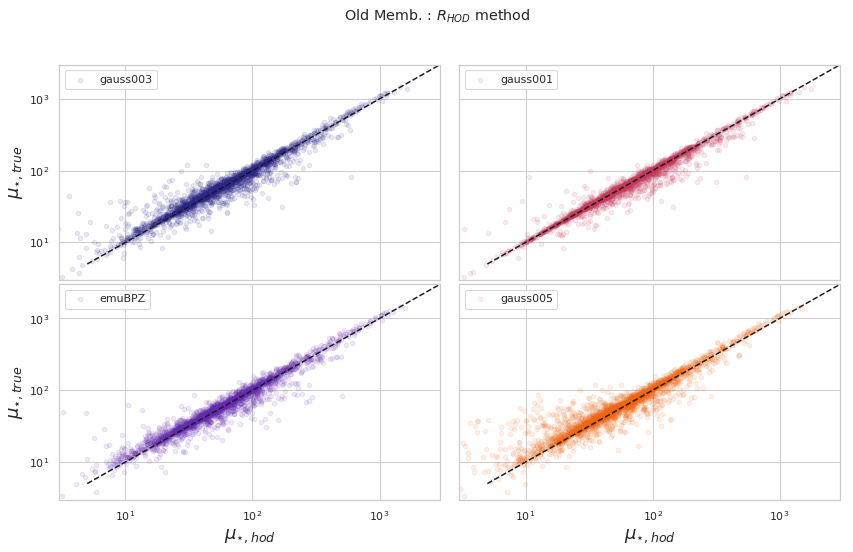

In [95]:
xlabel=r'$\mu_{\star,hod}$'
ylabel=r'$\mu_{\star,true}$'

fig, ax = plt.subplots(2, 2, sharey='all', sharex='all', figsize=(14,8))
fig.subplots_adjust(hspace=0.02,wspace=0.05)

ax = ax.flatten(order='F')

i=0
for d, run, label, color in zip(data_rhod,run_rhod,pz_label,colorGradient):
    ax[i].scatter(d['MU'],d['MU_TRUE'],label=label,color=color,alpha=0.1,s=20)
    ax[i].plot([5,3e3],[5,3e3],'k--')
    ax[i].legend()
    i+=1

ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].set_ylim(3,3e3)
ax[0].set_xlim(3,3e3)
ax[0].set_ylabel(ylabel,fontsize=18)
ax[1].set_ylabel(ylabel,fontsize=18)
ax[1].set_xlabel(xlabel,fontsize=18)
ax[3].set_xlabel(xlabel,fontsize=18)
plt.suptitle(r'Old Memb.$R_{HOD}$ method')

Text(0.5,0.98,'$R_{HOD}$ method')

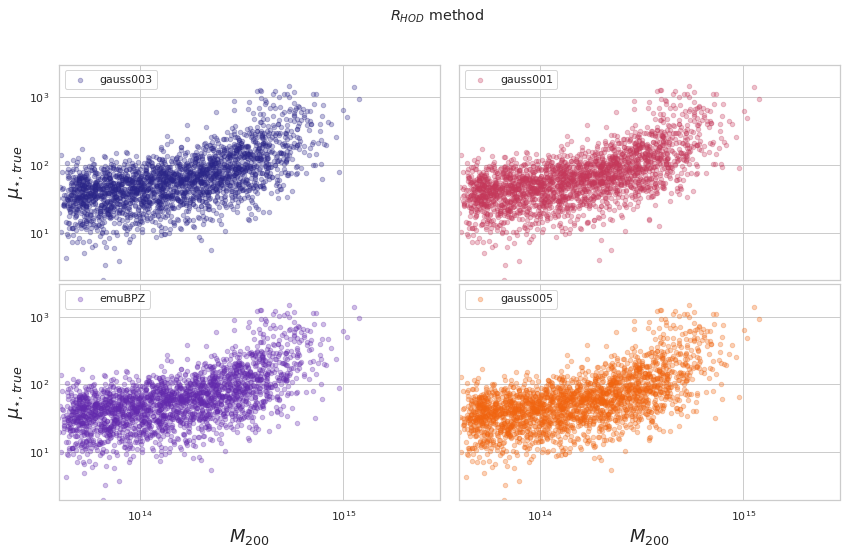

In [102]:
xlabel=r'$M_{200}$'
ylabel=r'$\mu_{\star,true}$'

fig, ax = plt.subplots(2, 2, sharey='all', sharex='all', figsize=(14,8))
fig.subplots_adjust(hspace=0.02,wspace=0.05)

ax = ax.flatten(order='F')

i=0
for d, run, label, color in zip(data_rhod,run_rhod,pz_label,colorGradient):
    ax[i].scatter(d['M200_true'],d['MU_TRUE'],label=label,color=color,alpha=0.3,s=20)
    #ax[i].scatter(d['M200_true'],d['MU_TRUE'],label=label,c=d['Ngals_true']**0.5,alpha=0.3,s=20)
    #ax[i].plot([5,3e3],[5,3e3],'k--')
    ax[i].legend()
    i+=1

ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].set_xlim(4e13,3e15)
ax[0].set_ylim(2,3e3)
ax[0].set_ylabel(ylabel,fontsize=18)
ax[1].set_ylabel(ylabel,fontsize=18)
ax[1].set_xlabel(xlabel,fontsize=18)
ax[3].set_xlabel(xlabel,fontsize=18)
plt.suptitle(r'$R_{HOD}$ method')

Text(0.5,0.98,'$R_{HOD}$ method')

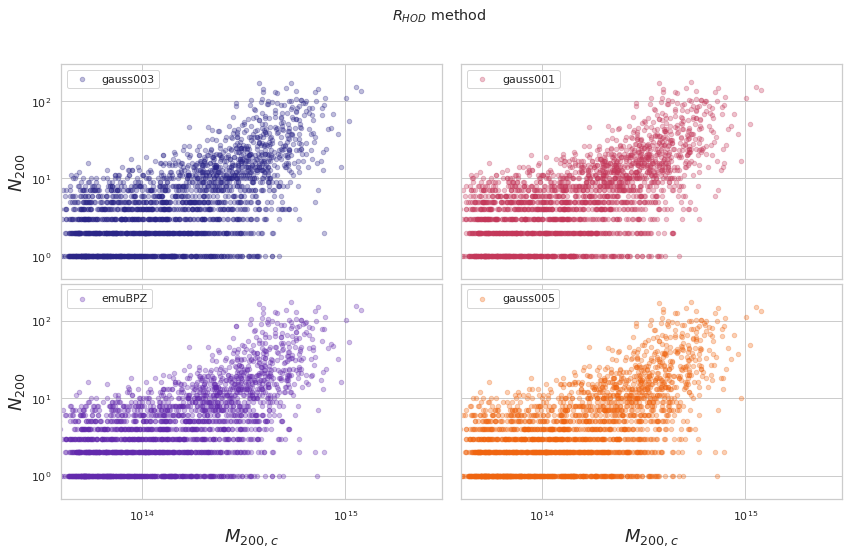

In [103]:
xlabel=r'$M_{200,c}$'
ylabel=r'$N_{200}$'

fig, ax = plt.subplots(2, 2, sharey='all', sharex='all', figsize=(14,8))
fig.subplots_adjust(hspace=0.02,wspace=0.05)

ax = ax.flatten(order='F')

i=0
for d, run, label, color in zip(data_rhod,run_rhod,pz_label,colorGradient):
    ax[i].scatter(d['M200_true'],d['Ngals_true'],label=label,color=color,alpha=0.3,s=20)
    #ax[i].plot([5,3e3],[5,3e3],'k--')
    ax[i].legend()
    i+=1

ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].set_xlim(4e13,3e15)
ax[0].set_ylim(0.5,3e2)
ax[0].set_ylabel(ylabel,fontsize=18)
ax[1].set_ylabel(ylabel,fontsize=18)
ax[1].set_xlabel(xlabel,fontsize=18)
ax[3].set_xlabel(xlabel,fontsize=18)
plt.suptitle(r'$R_{HOD}$ method')

Text(0.5,0.98,'$R_{HOD}$ method')

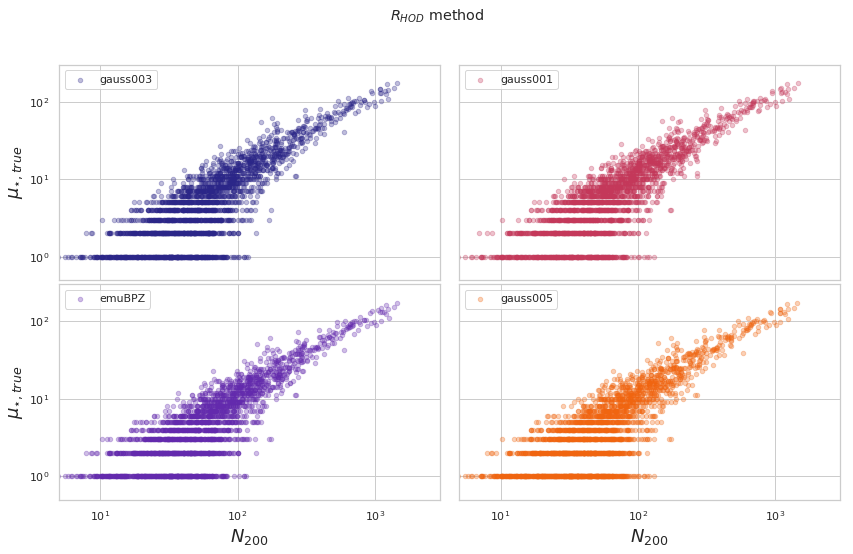

In [105]:
xlabel=r'$N_{200}$'
ylabel=r'$\mu_{\star,true}$'

fig, ax = plt.subplots(2, 2, sharey='all', sharex='all', figsize=(14,8))
fig.subplots_adjust(hspace=0.02,wspace=0.05)

ax = ax.flatten(order='F')

i=0
for d, run, label, color in zip(data_rhod,run_rhod,pz_label,colorGradient):
    ax[i].scatter(d['MU_TRUE'],d['Ngals_true'],label=label,color=color,alpha=0.3,s=20)
    #ax[i].plot([5,3e3],[5,3e3],'k--')
    ax[i].legend()
    i+=1

ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].set_xlim(5,3e3)
ax[0].set_ylim(0.5,3e2)
ax[0].set_ylabel(ylabel,fontsize=18)
ax[1].set_ylabel(ylabel,fontsize=18)
ax[1].set_xlabel(xlabel,fontsize=18)
ax[3].set_xlabel(xlabel,fontsize=18)
plt.suptitle(r'$R_{HOD}$ method')

### Auxialiry Functions

In [25]:
def makeBins(variable,xedges):
    xbins = (xedges[1:]+xedges[:-1])/2
    indices = [ np.where((variable >= xedges[i]) & (variable <= xedges[i + 1]))[0] for i in range(len(xedges)-1)]
    return indices, xbins

def splitBins(var):
    nmin = np.nanmin(var)
    n1 = np.percentile(var,10)
    n2 = np.percentile(var,20)
    n3 = np.percentile(var,30)
    n4 = np.percentile(var,40)
    n5 = np.percentile(var,50)
    n6 = np.percentile(var,60)
    n7 = np.percentile(var,70)
    n8 = np.percentile(var,80)
    n9 = np.percentile(var,90)
    nmax = np.max(var)
    
    return np.array([nmin,n1,n2,n3,n4,n5,n6,n7,n8,n9,nmax])


def splitBins6(var):
    nmin = np.nanmin(var)
    n1 = np.percentile(var,15)
    n2 = np.percentile(var,30)
    n3 = np.percentile(var,45)
    n4 = np.percentile(var,60)
    n5 = np.percentile(var,70)
    n6 = np.percentile(var,85)
    nmax = np.max(var)
    
    return np.array([nmin,n1,n2,n3,n4,n5,n6,nmax])

In [26]:
import scipy
def compute_fractional_error(x,y,errx,erry,eps=1e-9):
    y    += eps
    z     = (x/y)
    errz  = z*np.sqrt((errx/(x+eps))**2+(erry/y)**2)
    return errz

def sigma68(x):
    xlo = np.nanpercentile(x,16)
    xhi = np.nanpercentile(x,84)
    return (xhi-xlo)/2

def plot_frac_error(xvar,yvar1,yvar2, err1, err2, ax=None, co='r',label=None, xbins=None):
    if ax is None: ax = plt.axes()
    
    if xbins is None:
        xbins = splitBins6(xvar)
    
    eps = 1e-9
    w = np.where(yvar2>0.)[0]
    residual = (yvar1[w]/yvar2[w])
    
    keys, xvarb = makeBins(xvar[w],xbins)
    xvarb_std = np.diff(xbins)/2
    #residual = (yvar1/(yvar2+eps))
    #zerr = compute_fractional_error(yvar1,yvar2,err1,err2)
    
    residualb = np.array([np.nanmedian(residual[idx]) for idx in keys])
    lw = np.array([np.nanpercentile(residual[idx],16) for idx in keys])
    up = np.array([np.nanpercentile(residual[idx],84) for idx in keys])
    residualb_std = np.array([residualb-lw ,up-residualb])
    residualb_std2 = np.array([np.nanstd(residual[idx]) for idx in keys])
    
    #print('mean residual:',np.nanmean(residualb))
    #print('std  residual:',np.nanmean(residualb_std))
    #print()

#     ax.scatter(xvar,residual,color=cl,alpha=0.25,s=75)
#     ax.errorbar(xvarb,residualb,xerr=xvarb_std,yerr=[((residualb-lw)**2+residualb_std2**2)**(1/2) ,((up-residualb)**2+residualb_std2**2)**(1/2)],color=cl,fmt='o',label=lb)
    ax.errorbar(xvarb,residualb,xerr=xvarb_std,yerr=[residualb-lw ,up-residualb],color=color,fmt='o',label=label)

    
def plot_residual(xvar,yvar1,yvar2, err1, err2, ax=None, co='r',label=None, xbins=None):
    if ax is None: ax = plt.axes()
    
    if xbins is None:
        xbins = splitBins6(xvar)
    
    keys, xvarb = makeBins(xvar,xbins)
    xvarb_std = np.diff(xbins)/2
    
    residual = (yvar1-yvar2)
    zerr     = (err1**2+err2**2)**(1/2)
    
    residualb = np.array([np.nanmedian(residual[idx]) for idx in keys])
    residualb_std = np.sqrt(np.array([sigma68(residual[idx])**2+np.nanmedian(zerr)**2 for idx in keys]))
    residualb_std2 = np.sqrt(np.array([sigma68(residual[idx])**2 for idx in keys]))
    
    rho = scipy.stats.pearsonr(xvar, residual)
    
    #ax.errorbar(xvar,residual,yerr=zerr,color=color,alpha=0.25,fmt='o')
    ax.errorbar(xvarb,residualb,xerr=xvarb_std,yerr=residualb_std,color=co,fmt='o',label=label)

def plot_log_residual(xvar,yvar1,yvar2, err1, err2, ax=None, co='r',label=None, xbins=None):
    if ax is None: ax = plt.axes()
    
    if xbins is None:
        xbins = splitBins6(xvar)
    
    keys, xvarb = makeBins(xvar,xbins)
    xvarb_std = np.diff(xbins)/2

    residual = np.log10(yvar1)-np.log10(yvar2)
    #zerr = compute_fractional_error(yvar1,yvar2,err1,err2)
    
    residualb = np.array([np.nanmedian(residual[idx]) for idx in keys])
    #residualb_std = np.sqrt(np.array([sigma68(residual[idx])**2+np.nanmedian(zerr)**2 for idx in keys]))
    residualb_std2 = np.sqrt(np.array([sigma68(residual[idx])**2 for idx in keys]))
    
    rho = scipy.stats.pearsonr(xvar, residual)
    
    #ax.errorbar(xvar,residual,yerr=zerr,color=color,alpha=0.25,fmt='o')
    ax.errorbar(xvarb,residualb,xerr=xvarb_std,yerr=residualb_std2,color=co,fmt='o',label=label)


In [27]:
def plot_scaling_relation(ngals,nt,title='Buzzard'):
    #nt_bins = splitBins(nt)
    nt_bins= np.logspace(np.nanmin(np.log10(nt)),np.nanmax(np.log10(nt)),12)
    keys, ntb = makeBins(nt,nt_bins)
    ntb_std = np.diff(nt_bins)/2
    
    ngalsb = np.array([np.mean(ngals[idx]) for idx in keys])
    ngalsb_std = np.array([np.std(ngals[idx]) for idx in keys])
    
    ## linear fit
    linreg=lin_reg(nt,ngals)
    
    idx = np.argsort(nt)
    xt,yh = nt[idx],linreg['Yhat'][idx]

    b0 = round(linreg['b0'],3)
    b1 = round(linreg['b1'],3)
    cb_u, cb_l = linreg['cb_u'], linreg['cb_l']


    fig = plt.figure(figsize=(10,8))
    
    sc = plt.scatter(nt,ngals,s=75, alpha=0.25, color=gray)#,label='$scatter = %.1f$'%(np.std(ngals-nt))
    plt.errorbar(ntb,ngalsb,xerr=ntb_std,yerr=ngalsb_std,color=blue,linewidth=2.,fmt='o')
    
#     plt.plot(xt,yh, color="r",label='y=%.2f+%.2fx'%(b0,b1))
#     plt.fill_between(xt, cb_l, cb_u, color="gray", alpha=0.25, label='_nolabel_')
#     plt.plot(xt,cb_l, color="r", label='_nolabel_')
#     plt.plot(xt,cb_u, color="r", label='_nolabel_')

#     plt.scatter(nt,ngals2,alpha=0.2)
    plt.plot(np.linspace(1,900),np.linspace(1,900),linestyle='--',color='r')
    plt.xscale('log')
    plt.yscale('log')
    plt.ylim(1,900)
    plt.xlim(1,900)
    plt.xlabel(r'$N_{true}$',fontsize=22)
    plt.ylabel(r'$N_{obs}$',fontsize=22)
    plt.legend(fontsize=14)
    plt.title(title,fontsize=22)
    fig.tight_layout()
    
def lin_reg(X,Y):
    barX=np.mean(X); barY=np.mean(Y)
    XminusbarX=X-barX; YminusbarY=Y-barY
    b1=sum(XminusbarX*YminusbarY)/sum(XminusbarX**2)
    b0=barY-b1*barX
    Yhat=b0+b1*X
    e_i=Y-Yhat
    sse=np.sum(e_i**2)
    ssr=np.sum((Yhat-barY )**2)
    n=len(X)
    MSE=sse/np.float(n-2)

    s_of_yh_hat=np.sqrt(MSE*(1.0/n+(X-barX)**2/sum(XminusbarX**2)))
    W=np.sqrt(2.0*st.f.ppf(0.95,2,n-2))

    cb_upper=Yhat+W*s_of_yh_hat
    cb_lower=Yhat-W*s_of_yh_hat
    idx=np.argsort(X)

    return {'Yhat':Yhat,'b0':b0,'b1':b1,'cb_u':cb_upper[idx], 'cb_l': cb_lower[idx]}

In [28]:
def makeBins(variable,xedges):
    xbins = (xedges[1:]+xedges[:-1])/2
    indices = [ np.where((variable >= xedges[i]) & (variable <= xedges[i + 1]))[0] for i in range(len(xedges)-1)]
    return indices, xbins

def splitBins(var):
    nmin = np.nanmin(var)
    n1 = np.percentile(var,10)
    n2 = np.percentile(var,20)
    n3 = np.percentile(var,30)
    n4 = np.percentile(var,40)
    n5 = np.percentile(var,50)
    n6 = np.percentile(var,60)
    n7 = np.percentile(var,70)
    n8 = np.percentile(var,80)
    n9 = np.percentile(var,90)
    nmax = np.max(var)
    
    return np.array([nmin,n1,n2,n3,n4,n5,n6,n7,n8,n9,nmax])

In [29]:
def plot_residual(xvar,yvar1,yvar2, ax=None, xlabel='redshift', xbins=None):
    if ax is None: ax = plt.axes()
    
    if xbins is None:
        xbins = splitBins(xvar)
    keys, xvarb = makeBins(xvar,xbins)
    xvarb_std = np.diff(xbins)/2

    residual = (yvar1-yvar2)/yvar2

    residualb = np.array([np.nanmedian(residual[idx]) for idx in keys])
    residualb_std = np.array([np.nanstd(residual[idx]) for idx in keys])
    
    print('mean residual:',np.round(np.mean(residualb),3))
    print('std  residual:',np.round(np.min(residualb_std),3))
    print()
#     w = np.where(norm<2)[0]
    ax.scatter(xvar,residual,color='#A6ACAF',alpha=0.25,s=50)
#     ax.scatter(xvar[w],residual[w],color=red,alpha=0.5,s=75)
    ax.errorbar(xvarb,residualb,xerr=xvarb_std,yerr=residualb_std,color='#2E86C1',fmt='o')

    ax.set_xlabel(xlabel,fontsize=18)
    # ax.set_ylabel(r'$r_{200}-r_{200,HOD}

In [38]:
d = data_rhod[1]

('mean residual:', -0.006)
('std  residual:', 0.307)
()
('mean residual:', -0.026)
('std  residual:', 0.149)
()
('mean residual:', -0.002)
('std  residual:', 0.234)
()


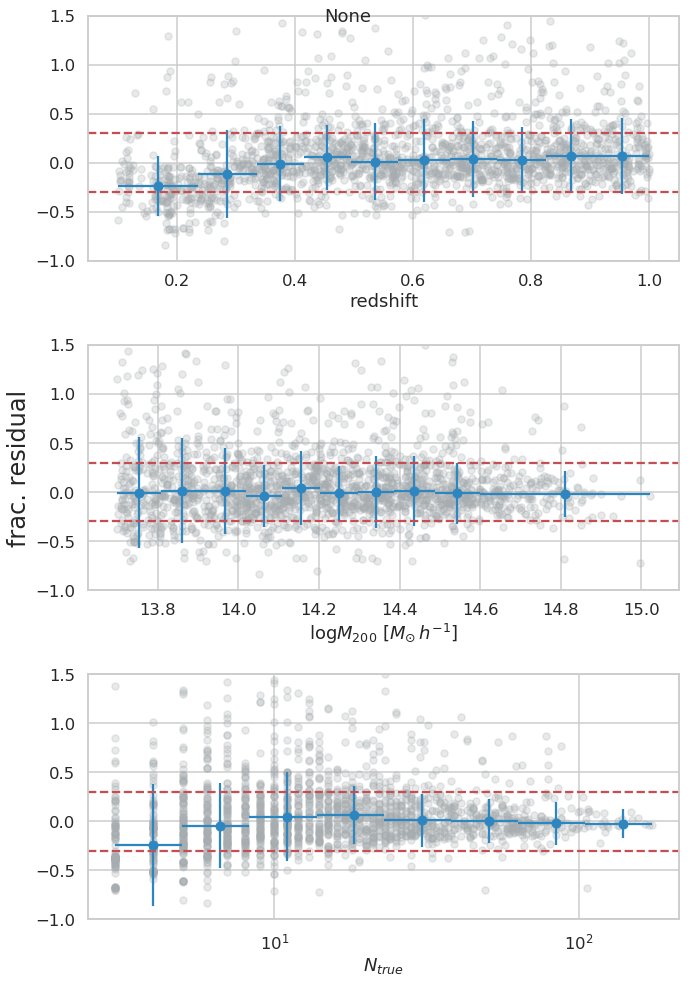

In [39]:
w, = np.where(d['Ngals_true']>2)
yvar1=d['Ngals'][w]
yvar2= d['Ngals_true'][w]
logm = np.log10(d['M200_true'])[w]
zcls = d['redshift'][w]
ntru = d['Ngals_true'][w]

ymin,ymax = -1.,1.5

ngbins = np.logspace(np.min(np.log10(yvar2)),np.max(np.log10(yvar2)),9)
mbins = np.logspace(np.min(logm),np.max(logm),9)

ylabel=r'frac. residual'
fig, ax = plt.subplots(3, 1, sharey='col', figsize=(10,14))
fig.subplots_adjust(hspace=0.4,wspace=0.6)
plot_residual(zcls,yvar1,yvar2,ax=ax[0])
plot_residual(ntru,yvar1,yvar2,ax=ax[2],xlabel=r'$N_{true}$',xbins=ngbins)
plot_residual(logm,yvar1,yvar2,ax=ax[1],xlabel=r'$\log{M_{200}}$ [$M_{\odot}\, h^{-1}$]')

# ax[0].set_title(r'$r_{200,HOD}-r_{200}$ [Mpc $h^{-1}$]',fontsize=18)
# fig.text(0.01, 0.5, ylabel, ha='center', va='center', rotation='vertical',fontsize=24)
fig.suptitle(None,fontsize=18)


ax[1].set_ylabel(ylabel,fontsize=24)
ax[2].set_xscale('log')
ax[0].set_ylim(ymin,ymax)
for i in range(3):
    ax[i].axhline(0.3,color='r',linestyle='--')
    ax[i].axhline(-0.3,color='r',linestyle='--')
fig.tight_layout()
plt.savefig('fig_4b_res_nobs_ntrue_pz_005_r200hod.png',bb_box='tight')

In [66]:
norm = d['Norm']
nbkg = d['Nbkg']
zcls = d['redshift']
ngals = d['Ngals']
ntrue = d['Ngals_true']
nbkgt = d['Nbkg_true']
M200  = d['M200_true']
residual = (ngals-ntrue)/ntrue

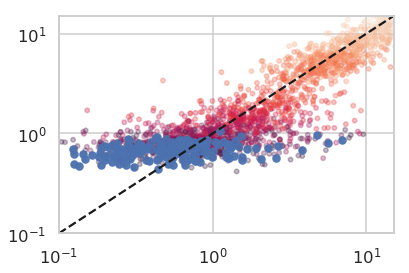

In [67]:
# idx = np.abs(residual)>0.5
idx =zcls<0.2
xvec = np.linspace(0.1,300,100)
plt.scatter(nbkgt,nbkg,s=20,alpha=0.3,c=zcls)
plt.scatter(nbkgt[idx],nbkg[idx],s=50,alpha=0.9,color='b')
plt.plot(xvec,xvec,ls='--',color='k')
plt.ylim(.1,15)
plt.xlim(.1,15)
plt.xscale('log')
plt.yscale('log')

In [431]:
import healpy as hp
def radec_pix(ra,dec,nside=1024,nest=True):
    return np.array(hp.ang2pix(nside,np.radians(90-dec),np.radians(ra),nest=True),dtype=np.int64)


In [248]:
nside=8192
ra,dec = d['RA'], d['DEC']

In [123]:
pixels = radec_pix(ra,dec,nside=nside,nest=True)

npix      = hp.nside2npix(nside)
area      = hp.nside2pixarea(nside,degrees=True)
hpxmap    = np.zeros(npix, dtype=np.int)
w, values = np.unique(pixels,return_counts=True)

values    = remove_iqr(values)
hpxmap[w] = values/area

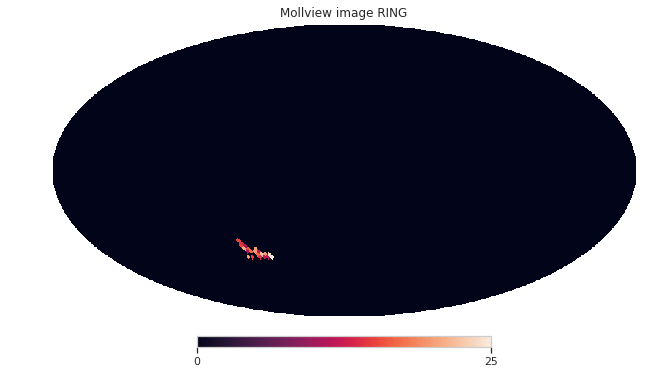

In [147]:
hp.mollview(hpxmap, title="Mollview image RING", nest=True)


In [158]:
### 3-sigma clip

def remove_iqr(values):
    q75,q25 = np.percentile(values,[75,25])
    intr_qr = q75-q25

    nmax = q75+(1.5*intr_qr)
    nmin = q25-(1.5*intr_qr)
    
    idx  = np.where((values < nmax) & (values > nmin))
    return idx

In [159]:
nmax

9.5

In [160]:
nmin

-2.5

In [161]:
values[values>nmax]

array([15, 10, 14, 20, 13, 25, 15, 11, 17, 16, 21, 15, 11, 14, 15, 12, 25,
       24, 14, 12, 22, 17, 20, 12, 20, 20, 24, 17, 22, 12, 17, 18, 21, 16,
       30, 15, 24, 24, 18, 10, 18, 19, 25, 16, 25, 19, 16, 16, 19, 12, 15,
       11, 16, 21, 12, 12, 21, 10, 13, 18, 19, 23, 10, 15, 20, 15, 13, 20,
       11, 17, 21, 15, 17, 10, 13, 12, 17, 13, 20, 12, 22, 19, 18, 11, 12,
       15, 23, 11, 18, 16, 12, 10, 12, 10, 16, 14, 13, 13, 15, 20, 12, 13,
       21, 11, 14, 16, 16, 19, 12, 10, 12, 17, 11, 14, 14, 19, 13, 12, 19,
       16, 21, 15, 13, 17])

In [162]:
2**13

8192

In [241]:
hp.nside2resol(32768,arcmin=True)*60

6.441537022157636

In [231]:
def commonValues(values):
	idx_sort = np.argsort(values)
	sorted_values = values[idx_sort]
	vals, idx_start, count = np.unique(sorted_values, return_counts=True,
                                return_index=True)

	# sets of indices
	res = np.split(idx_sort, idx_start[1:])
	#filter them with respect to their size, keeping only items occurring more than once

	vals = vals[count > 1]
	commonValuesIndicies = [ri for ri in res if ri.size>1]
	
	return commonValuesIndicies, vals

In [228]:
pz     = np.random.uniform(low=0.,high=1)*np.ones_like(ra)

array([ 9.95532187,  6.63688125,  9.29163375, 13.27376249,  8.62794562,
       16.59220312,  9.95532187,  7.30056937, 11.28269812, 10.61901   ,
       13.93745062,  9.95532187,  7.30056937,  9.29163375,  9.95532187,
        7.9642575 , 16.59220312, 15.92851499,  9.29163375,  7.9642575 ,
       14.60113874, 11.28269812, 13.27376249,  7.9642575 , 13.27376249,
       13.27376249, 15.92851499, 11.28269812, 14.60113874,  7.9642575 ,
       11.28269812, 11.94638624, 13.93745062,  5.309505  , 10.61901   ,
       19.91064374,  9.95532187, 15.92851499, 15.92851499, 11.94638624,
        6.63688125, 11.94638624, 12.61007437, 16.59220312, 10.61901   ,
        5.309505  , 16.59220312, 12.61007437, 10.61901   , 10.61901   ,
       12.61007437,  7.9642575 ,  4.64581687,  9.95532187,  7.30056937,
       10.61901   , 13.93745062,  7.9642575 ,  7.9642575 , 13.93745062,
        6.63688125,  8.62794562, 11.94638624, 12.61007437, 15.26482687,
        6.63688125,  9.95532187, 13.27376249,  9.95532187,  8.62

In [226]:
nside=32
pixels    = radec_pix(ra,dec,nside=nside,nest=True)

npix      = hp.nside2npix(nside)
hpxmap    = np.zeros(npix, dtype=np.int)
w         = np.unique(pixels)
groups    = commonValues(pixels)
pzmap     = np.array([np.sum(pz[idx]) for idx in groups])

idx            = remove_iqr(pzmap)
hpxmap[w[idx]] = pzmap[idx]

pixels_nonzero = hpxmap>0.
nbkg           = np.median(hpxmap[pixels_nonzero])
bkgIndices     = np.in1d(pixels,w[idx])

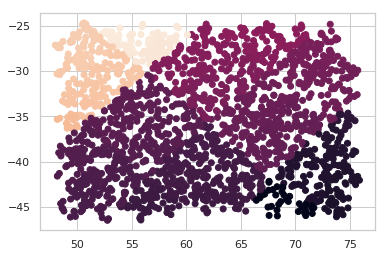

In [232]:
plt.scatter(ra,dec,c=pixels)

(array([ 0.,  1.,  0.,  0.,  1.,  5.,  8., 24., 10., 19., 11., 15.,  8.,
        15.,  3.,  6.,  4.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 <a list of 29 Patch objects>)

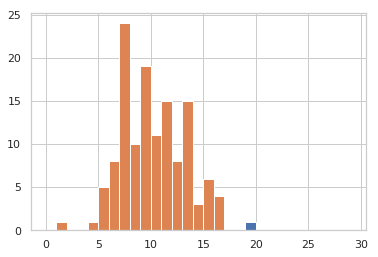

In [227]:
xbins = np.arange(0,30,1)
plt.hist(pzmap,bins=xbins)
plt.hist(pzmap[idx],bins=xbins)

In [183]:
nbkg

15.0

In [206]:
a = np.array([1,1])
w = np.array([1,0.5])

In [207]:
np.bincount(a,weights=w)

array([0. , 1.5])

In [203]:
np.unique(a)

array([1, 3])

In [325]:
d = data_rhod[2]
d1= data_rhod[1]

In [341]:
np.nanstd(d['Nbkg']/(d['Nbkg_true']+1e-9))/np.nanmean(d['Nbkg']/(d['Nbkg_true']+1e-9))

34.896512218896945

In [339]:
4*np.pi

12.566370614359172

In [328]:
d['Nbkg']

-0.007798592211502873
-0.007798592211502873
144648354.78644535
-0.007798592211502873
-0.007798592211502873
363817094.5028162
-0.007798592211502873
72143073.67815429
-0.007798592211502873
108565726.91208631
95558363.42293575


In [272]:
2*8192

16384

In [276]:
hp.nside2resol(8192,arcmin=True)

0.42943580147717575

In [290]:
13.2 - 13.2 % 2 

12.0